# QMDA Final Project

Goal here is to put uncertainty estimates on my gridded averages. Might also play around with lateral gradient problems, but not sure if I'll get to that or not.

In [61]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm import tqdm
from dask.diagnostics import ProgressBar

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

In [4]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p.nc')

In [34]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/global_kappa_epsilon.nc')

In [35]:
K_rho

<xarray.Dataset> Size: 606kB
Dimensions:  (z: 7, lon: 120, lat: 45)
Coordinates:
  * lat      (lat) float64 360B 66.0 63.0 60.0 57.0 ... -57.0 -60.0 -63.0 -66.0
  * lon      (lon) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
  * z        (z) float64 56B 375.0 625.0 875.0 ... 1.375e+03 1.625e+03 1.875e+03
Data variables:
    K        (z, lon, lat) float64 302kB ...
    e        (z, lon, lat) float64 302kB ...

In [36]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [5]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})
sa_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_e_3.nc', chunks={'N_PROF':100000})

In [19]:
ct_e = ct_e.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})
sa_e = sa_e.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})

In [75]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})
sa_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_3.nc', chunks={'N_PROF':100000})

In [76]:
ct_m = ct_m.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})
sa_m = sa_m.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})

In [22]:
ct_e_z2 = ct_e.differentiate(coord='pressure')**2
sa_e_z2 = sa_e.differentiate(coord='pressure')**2

In [78]:
ct_m_z2 = ct_m.differentiate(coord='pressure')**2
sa_m_z2 = sa_m.differentiate(coord='pressure')**2

In [24]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='profile', dim2='pressure')
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='profile', dim2='pressure')

CPU times: user 3min 10s, sys: 57.7 s, total: 4min 8s
Wall time: 3min 32s


In [25]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

sa_e_z2_filt.name = 'sa_e_z2_filt'
sa_e_z2_filt = sa_e_z2_filt.to_dataset()

In [79]:
ct_m_z2.name = 'ct_m_z2'
ct_m_z2 = ct_m_z2.to_dataset()

sa_m_z2.name = 'sa_m_z2'
sa_m_z2 = sa_m_z2.to_dataset()

In [62]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    """
    Bin profiles into lon/lat boxes and compute mean, std, and count
    for ct_e_z2_filt across pressure levels.
    """

    def reduce_with_progress(func, skipna=True, suffix=""):
        print(f"\nStarting {func} reduction...")
        with ProgressBar():  # separate progress bar for each flox call
            out = xarray_reduce(
                ds,
                'lon',        # bin by longitude
                'lat',        # bin by latitude
                func=func,
                expected_groups=(
                    pd.IntervalIndex.from_breaks(lon_bins),
                    pd.IntervalIndex.from_breaks(lat_bins)
                ),
                fill_value=np.nan,
                skipna=skipna
            ).compute()
        # Rename variable to avoid merge conflicts
        out = out.rename({var: f"{var}{suffix}" for var in out.data_vars})
        print(f"{func} reduction complete.")
        return out

    # Step 1: Compute mean, std, count
    ds_mean  = reduce_with_progress('mean',  skipna=True,  suffix="_mean")
    ds_std   = reduce_with_progress('std',   skipna=True,  suffix="_std")
    ds_count = reduce_with_progress('count', skipna=False, suffix="_count")

    # Step 2: Merge results
    ds_binned = xr.merge([ds_mean, ds_std, ds_count])

    # Step 3: Rename bin dimensions
    ds_binned = ds_binned.rename_dims({
        'lon_bins': 'lon',
        'lat_bins': 'lat'
    }).rename_vars({
        'lon_bins': 'lon',
        'lat_bins': 'lat'
    })

    # Step 4: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 5: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'pressure'}  # keep pressure dimension
    }, periodic=['X'])

    return ds_gridded, grid

In [63]:
ct_var2, grid = get_ds_gridded(ct_e_z2_filt, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 14.23 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 35.54 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 6.65 s
count reduction complete.


In [74]:
sa_var2, grid = get_ds_gridded(sa_e_z2_filt, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 8.01 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 18.56 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 3.58 s
count reduction complete.


In [80]:
ct_var3, grid = get_ds_gridded(ct_m_z2, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 24.10 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 30.14 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 12.71 s
count reduction complete.


In [81]:
sa_var3, grid = get_ds_gridded(sa_m_z2, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 22.68 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 30.05 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 12.49 s
count reduction complete.


In [83]:
sa_var3

<xarray.Dataset> Size: 173MB
Dimensions:        (pressure: 1001, lon: 120, lat: 60, lon_left: 120,
                    lat_left: 60)
Coordinates:
  * pressure       (pressure) int64 8kB 0 2 4 6 8 ... 1992 1994 1996 1998 2000
  * lon            (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat            (lat) float64 480B -88.5 -85.5 -82.5 -79.5 ... 82.5 85.5 88.5
  * lon_left       (lon_left) float64 960B -180.0 -177.0 -174.0 ... 174.0 177.0
  * lat_left       (lat_left) float64 480B -90.0 -87.0 -84.0 ... 81.0 84.0 87.0
Data variables:
    sa_m_z2_mean   (pressure, lon, lat) float64 58MB nan nan nan ... nan nan nan
    sa_m_z2_std    (pressure, lon, lat) float64 58MB nan nan nan ... nan nan nan
    sa_m_z2_count  (pressure, lon, lat) float64 58MB nan nan nan ... nan nan nan

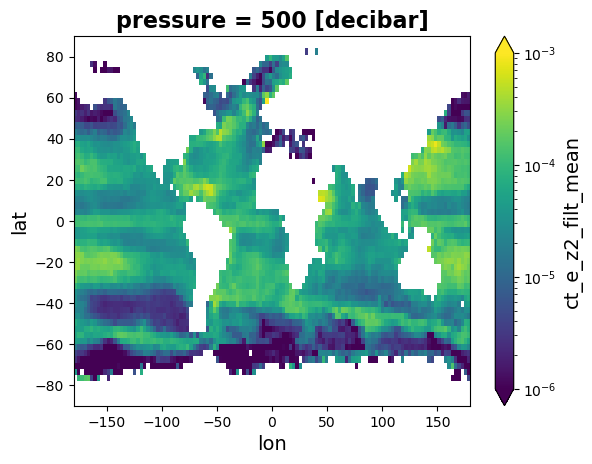

In [96]:
ct_var2.ct_e_z2_filt_mean.sel(pressure=500).plot(x='lon',y='lat', norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))

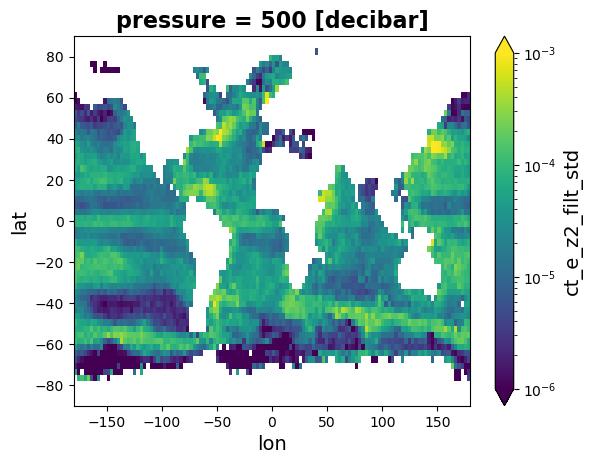

In [97]:
ct_var2.ct_e_z2_filt_std.sel(pressure=500).plot(x='lon',y='lat', norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))

In [100]:
# Select one pressure level, e.g. 1000 dbar
pres = 1000
mean = ct_var2['ct_e_z2_filt_mean'].sel(pressure=pres)
std  = ct_var2['ct_e_z2_filt_std'].sel(pressure=pres)
count = ct_var2['ct_e_z2_filt_count'].sel(pressure=pres)

# Standard error of the mean
sem = std / np.sqrt(count)

# 95% CI bounds
lower = mean - 2 * sem
upper = mean + 2 * sem

Text(0.5, 1.0, 'CI width (uncertainty)')

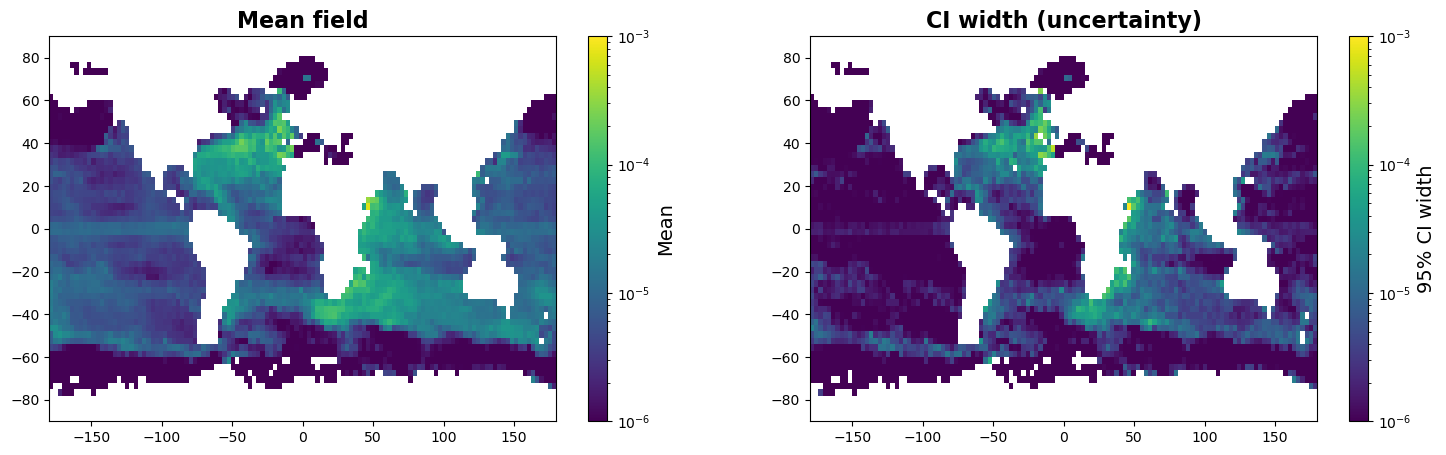

In [107]:
ci_width = upper - lower
fig, axs = plt.subplots(1,2, figsize=(18,5))

pcm1 = axs[0].pcolormesh(ct_var2['lon'], ct_var2['lat'], mean.T, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.colorbar(pcm1, ax=axs[0], label="Mean")
axs[0].set_title("Mean field")

pcm2 = axs[1].pcolormesh(ct_var2['lon'], ct_var2['lat'], ci_width.T, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.colorbar(pcm2, ax=axs[1], label="95% CI width")
axs[1].set_title("CI width (uncertainty)")